# Classic methods of text classification

### Yelp Review Rating Classification

A machine learning project for sentiment analysis and rating prediction of Yelp reviews using TF-IDF feature extraction and neural networks.

### Project Overview

This project implements a multi-class classification system to predict Yelp review ratings (1-5 stars) based on review text. The solution combines traditional NLP feature extraction methods with neural network classifiers.

### Dataset

We use the **Yelp Review Full** dataset from Hugging Face:
- **Dataset**: [Yelp/yelp_review_full](https://huggingface.co/datasets/Yelp/yelp_review_full)
- **Features**:
  - `text`: The review text content
  - `label`: Rating label (0-4, corresponding to 1-5 stars respectively)

### Technical Approach

#### Data Preprocessing
- Split the original training data to create a dedicated validation set
- Applied dataset size constraints (training set limited to 100,000 samples)
- Maintained proportional splits for validation and test sets

#### Feature Extraction
- **TF-IDF (Term Frequency-Inverse Document Frequency)** implementation
- **Bag-of-Words** representation using `TfidfVectorizer` from `scikit-learn`
- Text vectorization for neural network compatibility



Import libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.5.1+cu121


In [2]:
import wandb

# Loging to Weights&Biases website to monitor my experiments
wandb.login()

c:\Users\kacpe\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
c:\Users\kacpe\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may

True

# Load dataset

In [71]:
from datasets import load_dataset

ds = load_dataset("Yelp/yelp_review_full")

test_dataset = ds["test"]
splitted_dataset = ds["train"].train_test_split(test_size=0.2)
train_dataset = splitted_dataset["train"]
val_dataset = splitted_dataset["test"]

# Create smaller data subsets
train_dataset = train_dataset.shuffle().select(range(int(len(train_dataset)*0.1)))
val_dataset = val_dataset.shuffle().select(range(int(len(val_dataset)*0.1)))
test_dataset = test_dataset.shuffle().select(range(int(len(test_dataset)*0.4)))

print(f"Test set size: {len(test_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Training set size: {len(train_dataset)}")

sample = train_dataset[123]
print(f"\nExample element from the dataset:")
print(f"{sample["text"]=}")
print(f"{sample["label"]=}")

Test set size: 20000
Validation set size: 13000
Training set size: 52000

Example element from the dataset:
sample["text"]='Two words: Absolute Garbage\\n\\nEverything, the staff, the food, the cleanliness, garbage.'
sample["label"]=0


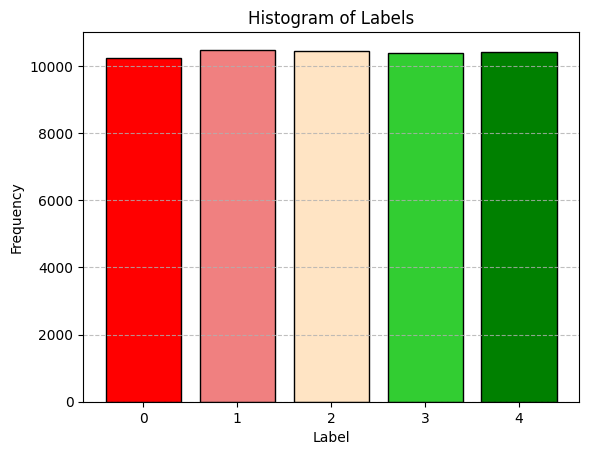

In [72]:
unique_labels, counts = np.unique(train_dataset["label"], return_counts=True)

plt.bar(unique_labels, counts, color=["red", "lightcoral", "bisque", "limegreen", "green"], edgecolor="black")
plt.title("Histogram of Labels")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.xticks(unique_labels)
plt.grid(axis="y", linestyle="--", alpha=0.8)
plt.show()

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from tqdm import tqdm

vocab_size = 5000

vectorizer = TfidfVectorizer(
    max_features=vocab_size,
    lowercase=True,
    analyzer="word",
    ngram_range=(1, 1),
    stop_words="english"
)

# Feature extraction
train_tfidf_features = vectorizer.fit_transform(train_dataset["text"])
# On validation and test sets we use transform() function which extracts the same features as on the training set
val_tfidf_features = vectorizer.transform(val_dataset["text"])
test_tfidf_features = vectorizer.transform(test_dataset["text"])

print(f"TF-IDF matrix size for training set: {train_tfidf_features.shape}")
print(f"{train_tfidf_features.dtype=}\n")

feature_names = vectorizer.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")
print(f"Example features: {np.random.choice(feature_names, 20)}\n")

TF-IDF matrix size for training set: (52000, 5000)
train_tfidf_features.dtype=dtype('float64')

Number of features: 5000
Example features: ['messed' 'student' 'increase' 'mcdonalds' 'une' 'disorganized' 'mr'
 'legs' 'reservations' 'mex' 'fab' 'basic' 'arrival' 'cinnamon' 'convince'
 'medium' 'described' 'slimy' 'tasteless' 'roof']



Average number of non-zero features in samples: 45.05


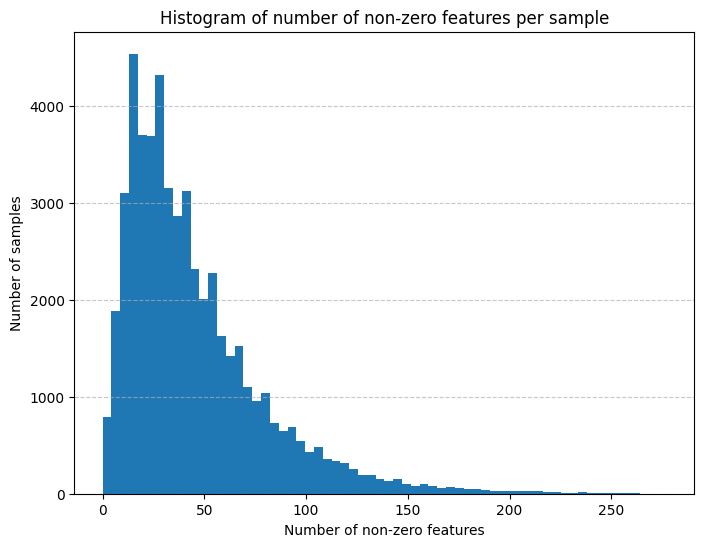

In [74]:
non_zero_counts = np.diff(train_tfidf_features.indptr)
print(f"Average number of non-zero features in samples: {non_zero_counts.mean():.2f}")

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(non_zero_counts, bins=64)
plt.title("Histogram of number of non-zero features per sample")
plt.xlabel("Number of non-zero features")
plt.ylabel("Number of samples")
plt.grid(axis="y", linestyle="--", alpha=0.7)

In [75]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Create appropriate datasets using tfidf matrices
def make_dataset(tfidf_matrix, labels):
  dense_features = tfidf_matrix.astype(np.float32).todense()
  dataset = TensorDataset(torch.tensor(dense_features), torch.tensor(labels, dtype=torch.int64))
  return dataset

datasets = {
    "train": make_dataset(train_tfidf_features, train_dataset["label"]),
    "val": make_dataset(val_tfidf_features, val_dataset["label"]),
    "test": make_dataset(test_tfidf_features, test_dataset["label"])
}


train_loader = DataLoader(datasets["train"], shuffle=True, batch_size=256)
val_loader = DataLoader(datasets["val"], shuffle=False, batch_size=256)
test_loader = DataLoader(datasets["test"], shuffle=False, batch_size=256)

loaders = {"train" : train_loader,
           "val": val_loader,
           "test": test_loader}

In [76]:
import torch.nn as nn

# Different architectures
class SimpleNet(nn.Module):
  def __init__(self, vocab_size: int, num_classes: int):
     super().__init__()
     self.fc1 = nn.Linear(vocab_size, 128)
     self.fc2 = nn.Linear(128, num_classes)
     self.relu = nn.ReLU()
     self.batchNorm1 = nn.BatchNorm1d(128)
     self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = self.dropout(self.relu(self.batchNorm1(self.fc1(x))))
    logits = self.dropout(self.relu(self.fc2(x)))
    return logits


class MediumNet(nn.Module):
  def __init__(self, vocab_size: int, num_classes: int):
     super().__init__()
     self.fc1 = nn.Linear(vocab_size, 256)
     self.fc2 = nn.Linear(256, 128)
     self.fc3 = nn.Linear(128, num_classes)
     self.relu = nn.ReLU()
     self.dropout = nn.Dropout(0.2)
     self.batchNorm1 = nn.BatchNorm1d(256)
     self.batchNorm2 = nn.BatchNorm1d(128)

  def forward(self, x):
    x = self.dropout(self.relu(self.batchNorm1(self.fc1(x))))
    x = self.dropout(self.relu(self.batchNorm2(self.fc2(x))))
    logits = self.fc3(x)
    return logits

class LargeNet(nn.Module):
  def __init__(self, vocab_size: int, num_classes: int):
    super().__init__()
    self.fc1 = nn.Linear(vocab_size, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, num_classes)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.2)
    self.batchNorm1 = nn.BatchNorm1d(512)
    self.batchNorm2 = nn.BatchNorm1d(256)
    self.batchNorm3 = nn.BatchNorm1d(128)

  def forward(self, x):
    x = self.dropout(self.relu(self.batchNorm1(self.fc1(x))))
    x = self.dropout(self.relu(self.batchNorm2(self.fc2(x))))
    x = self.dropout(self.relu(self.batchNorm3(self.fc3(x))))
    logits = self.fc4(x)
    return logits

In [77]:
import torchmetrics
import copy

# Training Loop
def train(model: nn.Module, loaders: dict[DataLoader], criterion: nn.Module,
          optimizer: torch.optim.Optimizer, lr_scheduler, num_epochs: int, device):

    metric_loss = torchmetrics.aggregation.MeanMetric().to(device)
    metric_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=5).to(device)
    earlyStopping = EarlyStopping(patience=5, delta=0.0001)

    # Run all epochs
    for epoch in range(1, num_epochs+1):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            for X_batch, target in tqdm(loaders[phase]):
                X_batch, target = X_batch.to(device), target.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    logits = model(X_batch)
                    _, preds = torch.max(logits, dim=1)
                    loss = criterion(logits, target)

                    metric_loss(loss)
                    metric_acc(preds, target)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

            accuracy = metric_acc.compute()
            mean_loss = metric_loss.compute()

            current_lr = lr_scheduler.get_last_lr()[0]
            print(f"(Epoch {epoch}/[{phase}]) Loss:\t{mean_loss:.3f}   Accuracy: {accuracy:.3f}   lr: {current_lr}")
            metrics = {
                f"{phase}/loss": mean_loss,
                f"{phase}/accuracy": accuracy,
                f"{phase}/lr": current_lr,
            }
            wandb.log(metrics, step=epoch)

            metric_loss.reset()
            metric_acc.reset()

        earlyStopping(mean_loss, model)
        if earlyStopping.early_stop:
            print(f"{20*"-"}Early stopping{20*"-"}")
            break
        lr_scheduler.step()

    earlyStopping.load_best_model(model)

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model: nn.Module):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model_state = copy.deepcopy(model.state_dict())
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.counter = 0

    def load_best_model(self, model: nn.Module):
        model.load_state_dict(self.best_model_state)





In [78]:
# Setting methods and parameters for training

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

num_epochs = 50
criterion = nn.CrossEntropyLoss()
classifiers = {"model1" : SimpleNet(vocab_size, 5),
               "model2" : MediumNet(vocab_size, 5),
               "model3" : LargeNet(vocab_size, 5)}


for name, model in classifiers.items():
  print(f"Trenowanie modelu: {name}")
  model = model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=2e-3, weight_decay=1e-4)
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
  run = wandb.init(
    project="3DifferentNeuralNetsExperiments_v23",
    name=name,
    config={
        "model": name,
        "vocab_size": vocab_size,
        "num_classes": 5,
        "optimizer": "SGD",
        "lr": 2e-3,
        "weight_decay": 1e-4,
        "scheduler": "StepLR",
        "step_size":10,
        "gamma": 0.9,
        "num_epochs": num_epochs
    }
  )
  train(model, loaders, criterion, optimizer, lr_scheduler, num_epochs, device)
  run.finish()


Trenowanie modelu: model1


100%|██████████| 204/204 [00:02<00:00, 97.14it/s] 


(Epoch 1/[train]) Loss:	1.610   Accuracy: 0.242   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 111.76it/s]


(Epoch 1/[val]) Loss:	1.555   Accuracy: 0.322   lr: 0.002


100%|██████████| 204/204 [00:01<00:00, 104.78it/s]


(Epoch 2/[train]) Loss:	1.530   Accuracy: 0.329   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 114.15it/s]


(Epoch 2/[val]) Loss:	1.474   Accuracy: 0.397   lr: 0.002


100%|██████████| 204/204 [00:01<00:00, 103.78it/s]


(Epoch 3/[train]) Loss:	1.463   Accuracy: 0.375   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 111.30it/s]


(Epoch 3/[val]) Loss:	1.406   Accuracy: 0.436   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 98.95it/s] 


(Epoch 4/[train]) Loss:	1.407   Accuracy: 0.410   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 107.38it/s]


(Epoch 4/[val]) Loss:	1.346   Accuracy: 0.464   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 101.71it/s]


(Epoch 5/[train]) Loss:	1.367   Accuracy: 0.431   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 119.71it/s]


(Epoch 5/[val]) Loss:	1.303   Accuracy: 0.482   lr: 0.002


100%|██████████| 204/204 [00:01<00:00, 102.16it/s]


(Epoch 6/[train]) Loss:	1.329   Accuracy: 0.453   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 116.40it/s]


(Epoch 6/[val]) Loss:	1.269   Accuracy: 0.493   lr: 0.002


100%|██████████| 204/204 [00:01<00:00, 103.47it/s]


(Epoch 7/[train]) Loss:	1.306   Accuracy: 0.465   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 77.51it/s]


(Epoch 7/[val]) Loss:	1.245   Accuracy: 0.504   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 97.94it/s] 


(Epoch 8/[train]) Loss:	1.285   Accuracy: 0.478   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 115.02it/s]


(Epoch 8/[val]) Loss:	1.225   Accuracy: 0.512   lr: 0.002


100%|██████████| 204/204 [00:01<00:00, 105.14it/s]


(Epoch 9/[train]) Loss:	1.269   Accuracy: 0.489   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 119.62it/s]


(Epoch 9/[val]) Loss:	1.209   Accuracy: 0.520   lr: 0.002


100%|██████████| 204/204 [00:01<00:00, 106.14it/s]


(Epoch 10/[train]) Loss:	1.257   Accuracy: 0.494   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 112.44it/s]


(Epoch 10/[val]) Loss:	1.197   Accuracy: 0.526   lr: 0.002


100%|██████████| 204/204 [00:01<00:00, 102.69it/s]


(Epoch 11/[train]) Loss:	1.240   Accuracy: 0.503   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 114.82it/s]


(Epoch 11/[val]) Loss:	1.188   Accuracy: 0.529   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:01<00:00, 104.71it/s]


(Epoch 12/[train]) Loss:	1.230   Accuracy: 0.507   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 112.70it/s]


(Epoch 12/[val]) Loss:	1.179   Accuracy: 0.532   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:01<00:00, 105.81it/s]


(Epoch 13/[train]) Loss:	1.221   Accuracy: 0.513   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 115.97it/s]


(Epoch 13/[val]) Loss:	1.174   Accuracy: 0.536   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:01<00:00, 106.08it/s]


(Epoch 14/[train]) Loss:	1.212   Accuracy: 0.516   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 104.14it/s]


(Epoch 14/[val]) Loss:	1.166   Accuracy: 0.538   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 98.48it/s] 


(Epoch 15/[train]) Loss:	1.206   Accuracy: 0.521   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 114.81it/s]


(Epoch 15/[val]) Loss:	1.161   Accuracy: 0.539   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:01<00:00, 104.57it/s]


(Epoch 16/[train]) Loss:	1.196   Accuracy: 0.526   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 117.12it/s]


(Epoch 16/[val]) Loss:	1.157   Accuracy: 0.542   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 98.07it/s] 


(Epoch 17/[train]) Loss:	1.188   Accuracy: 0.533   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 121.56it/s]


(Epoch 17/[val]) Loss:	1.152   Accuracy: 0.542   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:01<00:00, 102.12it/s]


(Epoch 18/[train]) Loss:	1.185   Accuracy: 0.531   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 120.01it/s]


(Epoch 18/[val]) Loss:	1.149   Accuracy: 0.542   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:01<00:00, 102.71it/s]


(Epoch 19/[train]) Loss:	1.173   Accuracy: 0.538   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 116.65it/s]


(Epoch 19/[val]) Loss:	1.146   Accuracy: 0.543   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:01<00:00, 106.13it/s]


(Epoch 20/[train]) Loss:	1.166   Accuracy: 0.543   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 116.93it/s]


(Epoch 20/[val]) Loss:	1.145   Accuracy: 0.543   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:01<00:00, 105.15it/s]


(Epoch 21/[train]) Loss:	1.161   Accuracy: 0.544   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 119.28it/s]


(Epoch 21/[val]) Loss:	1.141   Accuracy: 0.546   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:01<00:00, 106.24it/s]


(Epoch 22/[train]) Loss:	1.149   Accuracy: 0.553   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 116.50it/s]


(Epoch 22/[val]) Loss:	1.139   Accuracy: 0.545   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:01<00:00, 104.44it/s]


(Epoch 23/[train]) Loss:	1.146   Accuracy: 0.552   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 109.87it/s]


(Epoch 23/[val]) Loss:	1.136   Accuracy: 0.545   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:01<00:00, 105.85it/s]


(Epoch 24/[train]) Loss:	1.141   Accuracy: 0.555   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 103.79it/s]


(Epoch 24/[val]) Loss:	1.135   Accuracy: 0.546   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:01<00:00, 104.13it/s]


(Epoch 25/[train]) Loss:	1.133   Accuracy: 0.560   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 115.86it/s]


(Epoch 25/[val]) Loss:	1.133   Accuracy: 0.546   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 96.88it/s] 


(Epoch 26/[train]) Loss:	1.129   Accuracy: 0.561   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 119.33it/s]


(Epoch 26/[val]) Loss:	1.132   Accuracy: 0.545   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:01<00:00, 106.10it/s]


(Epoch 27/[train]) Loss:	1.123   Accuracy: 0.568   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 118.80it/s]


(Epoch 27/[val]) Loss:	1.131   Accuracy: 0.547   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:01<00:00, 104.93it/s]


(Epoch 28/[train]) Loss:	1.119   Accuracy: 0.567   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 114.07it/s]


(Epoch 28/[val]) Loss:	1.131   Accuracy: 0.546   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:01<00:00, 105.32it/s]


(Epoch 29/[train]) Loss:	1.110   Accuracy: 0.572   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 118.57it/s]


(Epoch 29/[val]) Loss:	1.129   Accuracy: 0.547   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:01<00:00, 103.67it/s]


(Epoch 30/[train]) Loss:	1.101   Accuracy: 0.577   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 115.23it/s]


(Epoch 30/[val]) Loss:	1.127   Accuracy: 0.549   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:01<00:00, 104.58it/s]


(Epoch 31/[train]) Loss:	1.103   Accuracy: 0.576   lr: 0.001458


100%|██████████| 51/51 [00:00<00:00, 120.06it/s]


(Epoch 31/[val]) Loss:	1.127   Accuracy: 0.548   lr: 0.001458


100%|██████████| 204/204 [00:01<00:00, 105.66it/s]


(Epoch 32/[train]) Loss:	1.098   Accuracy: 0.578   lr: 0.001458


100%|██████████| 51/51 [00:00<00:00, 117.26it/s]


(Epoch 32/[val]) Loss:	1.126   Accuracy: 0.548   lr: 0.001458


100%|██████████| 204/204 [00:01<00:00, 103.32it/s]


(Epoch 33/[train]) Loss:	1.096   Accuracy: 0.577   lr: 0.001458


100%|██████████| 51/51 [00:00<00:00, 118.62it/s]


(Epoch 33/[val]) Loss:	1.127   Accuracy: 0.547   lr: 0.001458


100%|██████████| 204/204 [00:01<00:00, 104.50it/s]


(Epoch 34/[train]) Loss:	1.089   Accuracy: 0.581   lr: 0.001458


100%|██████████| 51/51 [00:00<00:00, 118.58it/s]


(Epoch 34/[val]) Loss:	1.126   Accuracy: 0.546   lr: 0.001458


100%|██████████| 204/204 [00:01<00:00, 106.20it/s]


(Epoch 35/[train]) Loss:	1.083   Accuracy: 0.588   lr: 0.001458


100%|██████████| 51/51 [00:00<00:00, 114.75it/s]


(Epoch 35/[val]) Loss:	1.126   Accuracy: 0.547   lr: 0.001458


100%|██████████| 204/204 [00:02<00:00, 95.74it/s] 


(Epoch 36/[train]) Loss:	1.076   Accuracy: 0.590   lr: 0.001458


100%|██████████| 51/51 [00:00<00:00, 110.49it/s]


(Epoch 36/[val]) Loss:	1.125   Accuracy: 0.547   lr: 0.001458


100%|██████████| 204/204 [00:02<00:00, 100.60it/s]


(Epoch 37/[train]) Loss:	1.075   Accuracy: 0.591   lr: 0.001458


100%|██████████| 51/51 [00:00<00:00, 115.05it/s]


(Epoch 37/[val]) Loss:	1.125   Accuracy: 0.547   lr: 0.001458


100%|██████████| 204/204 [00:01<00:00, 105.57it/s]


(Epoch 38/[train]) Loss:	1.064   Accuracy: 0.594   lr: 0.001458


100%|██████████| 51/51 [00:00<00:00, 119.51it/s]


(Epoch 38/[val]) Loss:	1.125   Accuracy: 0.546   lr: 0.001458


100%|██████████| 204/204 [00:01<00:00, 102.89it/s]


(Epoch 39/[train]) Loss:	1.064   Accuracy: 0.595   lr: 0.001458


100%|██████████| 51/51 [00:00<00:00, 116.21it/s]


(Epoch 39/[val]) Loss:	1.125   Accuracy: 0.546   lr: 0.001458


100%|██████████| 204/204 [00:02<00:00, 98.70it/s] 


(Epoch 40/[train]) Loss:	1.062   Accuracy: 0.595   lr: 0.001458


100%|██████████| 51/51 [00:00<00:00, 116.43it/s]


(Epoch 40/[val]) Loss:	1.125   Accuracy: 0.546   lr: 0.001458


100%|██████████| 204/204 [00:01<00:00, 103.71it/s]


(Epoch 41/[train]) Loss:	1.052   Accuracy: 0.601   lr: 0.0013122000000000001


100%|██████████| 51/51 [00:00<00:00, 114.08it/s]


(Epoch 41/[val]) Loss:	1.125   Accuracy: 0.544   lr: 0.0013122000000000001


100%|██████████| 204/204 [00:01<00:00, 106.44it/s]


(Epoch 42/[train]) Loss:	1.049   Accuracy: 0.602   lr: 0.0013122000000000001


100%|██████████| 51/51 [00:00<00:00, 118.38it/s]


(Epoch 42/[val]) Loss:	1.126   Accuracy: 0.546   lr: 0.0013122000000000001


100%|██████████| 204/204 [00:01<00:00, 105.01it/s]


(Epoch 43/[train]) Loss:	1.049   Accuracy: 0.603   lr: 0.0013122000000000001


100%|██████████| 51/51 [00:00<00:00, 106.26it/s]

(Epoch 43/[val]) Loss:	1.126   Accuracy: 0.545   lr: 0.0013122000000000001
--------------------Early stopping--------------------


train/accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
train/loss,█▇▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/lr,██████████▆▆▆▆▆▆▆▆▆▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▂▁▁
val/accuracy,▁▃▅▅▆▆▇▇▇▇▇█████████████████████████████
val/loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/lr,██████████▆▆▆▆▆▆▆▆▆▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▂▁▁
train/accuracy,0.60319
train/loss,1.04919
train/lr,0.00131
val/accuracy,0.54538
val/loss,1.12636


Trenowanie modelu: model2


100%|██████████| 204/204 [00:02<00:00, 87.20it/s]


(Epoch 1/[train]) Loss:	1.587   Accuracy: 0.269   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 113.96it/s]


(Epoch 1/[val]) Loss:	1.479   Accuracy: 0.370   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 80.31it/s]


(Epoch 2/[train]) Loss:	1.441   Accuracy: 0.377   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 115.98it/s]


(Epoch 2/[val]) Loss:	1.366   Accuracy: 0.432   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 86.19it/s]


(Epoch 3/[train]) Loss:	1.337   Accuracy: 0.438   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 105.38it/s]


(Epoch 3/[val]) Loss:	1.285   Accuracy: 0.468   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 83.28it/s]


(Epoch 4/[train]) Loss:	1.263   Accuracy: 0.469   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 108.67it/s]


(Epoch 4/[val]) Loss:	1.227   Accuracy: 0.489   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 82.23it/s]


(Epoch 5/[train]) Loss:	1.203   Accuracy: 0.495   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 103.12it/s]


(Epoch 5/[val]) Loss:	1.184   Accuracy: 0.505   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 84.51it/s]


(Epoch 6/[train]) Loss:	1.158   Accuracy: 0.514   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 98.30it/s] 


(Epoch 6/[val]) Loss:	1.149   Accuracy: 0.517   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 80.88it/s]


(Epoch 7/[train]) Loss:	1.122   Accuracy: 0.530   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 110.23it/s]


(Epoch 7/[val]) Loss:	1.125   Accuracy: 0.524   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 82.73it/s]


(Epoch 8/[train]) Loss:	1.090   Accuracy: 0.543   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 107.16it/s]


(Epoch 8/[val]) Loss:	1.104   Accuracy: 0.530   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 82.55it/s]


(Epoch 9/[train]) Loss:	1.063   Accuracy: 0.557   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 89.45it/s]


(Epoch 9/[val]) Loss:	1.088   Accuracy: 0.534   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 84.10it/s]


(Epoch 10/[train]) Loss:	1.038   Accuracy: 0.565   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 110.54it/s]


(Epoch 10/[val]) Loss:	1.076   Accuracy: 0.538   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 83.02it/s]


(Epoch 11/[train]) Loss:	1.019   Accuracy: 0.575   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 82.62it/s] 


(Epoch 11/[val]) Loss:	1.068   Accuracy: 0.541   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 82.94it/s]


(Epoch 12/[train]) Loss:	1.004   Accuracy: 0.580   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 115.14it/s]


(Epoch 12/[val]) Loss:	1.060   Accuracy: 0.544   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 85.83it/s]


(Epoch 13/[train]) Loss:	0.986   Accuracy: 0.588   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 112.16it/s]


(Epoch 13/[val]) Loss:	1.053   Accuracy: 0.546   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 84.22it/s]


(Epoch 14/[train]) Loss:	0.971   Accuracy: 0.595   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 115.27it/s]


(Epoch 14/[val]) Loss:	1.048   Accuracy: 0.549   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 83.47it/s]


(Epoch 15/[train]) Loss:	0.958   Accuracy: 0.601   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 108.70it/s]


(Epoch 15/[val]) Loss:	1.043   Accuracy: 0.551   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 86.75it/s]


(Epoch 16/[train]) Loss:	0.944   Accuracy: 0.607   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 112.27it/s]


(Epoch 16/[val]) Loss:	1.038   Accuracy: 0.552   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 85.29it/s]


(Epoch 17/[train]) Loss:	0.928   Accuracy: 0.619   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 114.07it/s]


(Epoch 17/[val]) Loss:	1.036   Accuracy: 0.553   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 81.20it/s]


(Epoch 18/[train]) Loss:	0.915   Accuracy: 0.621   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 113.02it/s]


(Epoch 18/[val]) Loss:	1.033   Accuracy: 0.555   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 85.74it/s]


(Epoch 19/[train]) Loss:	0.903   Accuracy: 0.626   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 115.06it/s]


(Epoch 19/[val]) Loss:	1.032   Accuracy: 0.556   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 83.60it/s]


(Epoch 20/[train]) Loss:	0.891   Accuracy: 0.632   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 113.07it/s]


(Epoch 20/[val]) Loss:	1.030   Accuracy: 0.556   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 77.81it/s]


(Epoch 21/[train]) Loss:	0.879   Accuracy: 0.641   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 113.72it/s]


(Epoch 21/[val]) Loss:	1.030   Accuracy: 0.556   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 84.55it/s]


(Epoch 22/[train]) Loss:	0.869   Accuracy: 0.644   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 109.95it/s]


(Epoch 22/[val]) Loss:	1.029   Accuracy: 0.556   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 83.22it/s]


(Epoch 23/[train]) Loss:	0.864   Accuracy: 0.646   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 95.06it/s] 


(Epoch 23/[val]) Loss:	1.029   Accuracy: 0.555   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 74.97it/s]


(Epoch 24/[train]) Loss:	0.847   Accuracy: 0.654   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 97.68it/s] 


(Epoch 24/[val]) Loss:	1.027   Accuracy: 0.554   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:03<00:00, 67.56it/s]


(Epoch 25/[train]) Loss:	0.839   Accuracy: 0.659   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 96.78it/s]


(Epoch 25/[val]) Loss:	1.028   Accuracy: 0.555   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 72.98it/s]


(Epoch 26/[train]) Loss:	0.827   Accuracy: 0.663   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 100.53it/s]


(Epoch 26/[val]) Loss:	1.029   Accuracy: 0.554   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 78.82it/s]


(Epoch 27/[train]) Loss:	0.817   Accuracy: 0.669   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 113.03it/s]


(Epoch 27/[val]) Loss:	1.031   Accuracy: 0.555   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 81.34it/s]


(Epoch 28/[train]) Loss:	0.805   Accuracy: 0.675   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 111.37it/s]


(Epoch 28/[val]) Loss:	1.033   Accuracy: 0.553   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 80.74it/s]


(Epoch 29/[train]) Loss:	0.793   Accuracy: 0.683   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 109.05it/s]

(Epoch 29/[val]) Loss:	1.034   Accuracy: 0.553   lr: 0.0016200000000000001
--------------------Early stopping--------------------


train/accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
train/loss,█▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train/lr,██████████▄▄▄▄▄▄▄▄▄▄▁▁▁▁▁▁▁▁▁
val/accuracy,▁▃▅▅▆▇▇▇▇▇▇██████████████████
val/loss,█▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/lr,██████████▄▄▄▄▄▄▄▄▄▄▁▁▁▁▁▁▁▁▁
train/accuracy,0.68296
train/loss,0.79342
train/lr,0.00162
val/accuracy,0.55292
val/loss,1.03367


Trenowanie modelu: model3


100%|██████████| 204/204 [00:03<00:00, 53.60it/s]


(Epoch 1/[train]) Loss:	1.616   Accuracy: 0.244   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 95.47it/s] 


(Epoch 1/[val]) Loss:	1.531   Accuracy: 0.334   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 52.15it/s]


(Epoch 2/[train]) Loss:	1.515   Accuracy: 0.327   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 92.86it/s]


(Epoch 2/[val]) Loss:	1.438   Accuracy: 0.405   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 57.97it/s]


(Epoch 3/[train]) Loss:	1.416   Accuracy: 0.391   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 96.14it/s]


(Epoch 3/[val]) Loss:	1.349   Accuracy: 0.445   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 56.51it/s]


(Epoch 4/[train]) Loss:	1.330   Accuracy: 0.436   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 100.53it/s]


(Epoch 4/[val]) Loss:	1.278   Accuracy: 0.467   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 59.34it/s]


(Epoch 5/[train]) Loss:	1.260   Accuracy: 0.462   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 99.89it/s] 


(Epoch 5/[val]) Loss:	1.223   Accuracy: 0.486   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 57.95it/s]


(Epoch 6/[train]) Loss:	1.207   Accuracy: 0.487   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 97.76it/s]


(Epoch 6/[val]) Loss:	1.182   Accuracy: 0.500   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 59.97it/s]


(Epoch 7/[train]) Loss:	1.163   Accuracy: 0.506   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 99.84it/s] 


(Epoch 7/[val]) Loss:	1.151   Accuracy: 0.511   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 59.89it/s]


(Epoch 8/[train]) Loss:	1.125   Accuracy: 0.524   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 98.10it/s] 


(Epoch 8/[val]) Loss:	1.127   Accuracy: 0.517   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 58.92it/s]


(Epoch 9/[train]) Loss:	1.098   Accuracy: 0.533   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 98.93it/s]


(Epoch 9/[val]) Loss:	1.105   Accuracy: 0.526   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 59.18it/s]


(Epoch 10/[train]) Loss:	1.067   Accuracy: 0.548   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 101.13it/s]


(Epoch 10/[val]) Loss:	1.091   Accuracy: 0.531   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 57.22it/s]


(Epoch 11/[train]) Loss:	1.048   Accuracy: 0.553   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 99.17it/s] 


(Epoch 11/[val]) Loss:	1.077   Accuracy: 0.536   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 59.79it/s]


(Epoch 12/[train]) Loss:	1.029   Accuracy: 0.563   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 100.04it/s]


(Epoch 12/[val]) Loss:	1.070   Accuracy: 0.539   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:04<00:00, 49.80it/s]


(Epoch 13/[train]) Loss:	1.012   Accuracy: 0.574   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 88.03it/s]


(Epoch 13/[val]) Loss:	1.061   Accuracy: 0.541   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 53.95it/s]


(Epoch 14/[train]) Loss:	0.995   Accuracy: 0.578   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 86.32it/s]


(Epoch 14/[val]) Loss:	1.056   Accuracy: 0.545   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 58.13it/s]


(Epoch 15/[train]) Loss:	0.976   Accuracy: 0.588   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 101.34it/s]


(Epoch 15/[val]) Loss:	1.049   Accuracy: 0.547   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 61.57it/s]


(Epoch 16/[train]) Loss:	0.963   Accuracy: 0.593   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 101.78it/s]


(Epoch 16/[val]) Loss:	1.045   Accuracy: 0.549   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 54.03it/s]


(Epoch 17/[train]) Loss:	0.949   Accuracy: 0.600   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 85.35it/s]


(Epoch 17/[val]) Loss:	1.041   Accuracy: 0.551   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 60.86it/s]


(Epoch 18/[train]) Loss:	0.935   Accuracy: 0.607   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 103.23it/s]


(Epoch 18/[val]) Loss:	1.037   Accuracy: 0.552   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 57.24it/s]


(Epoch 19/[train]) Loss:	0.923   Accuracy: 0.613   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 99.97it/s] 


(Epoch 19/[val]) Loss:	1.035   Accuracy: 0.553   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 57.14it/s]


(Epoch 20/[train]) Loss:	0.907   Accuracy: 0.622   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 98.67it/s] 


(Epoch 20/[val]) Loss:	1.033   Accuracy: 0.553   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 58.91it/s]


(Epoch 21/[train]) Loss:	0.895   Accuracy: 0.625   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 99.58it/s] 


(Epoch 21/[val]) Loss:	1.031   Accuracy: 0.554   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:03<00:00, 59.49it/s]


(Epoch 22/[train]) Loss:	0.884   Accuracy: 0.630   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 100.44it/s]


(Epoch 22/[val]) Loss:	1.035   Accuracy: 0.553   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:03<00:00, 59.77it/s]


(Epoch 23/[train]) Loss:	0.870   Accuracy: 0.635   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 95.82it/s]


(Epoch 23/[val]) Loss:	1.030   Accuracy: 0.555   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:03<00:00, 59.90it/s]


(Epoch 24/[train]) Loss:	0.859   Accuracy: 0.643   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 100.63it/s]


(Epoch 24/[val]) Loss:	1.031   Accuracy: 0.556   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:03<00:00, 58.17it/s]


(Epoch 25/[train]) Loss:	0.845   Accuracy: 0.647   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 75.92it/s]


(Epoch 25/[val]) Loss:	1.036   Accuracy: 0.553   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:04<00:00, 50.15it/s]


(Epoch 26/[train]) Loss:	0.837   Accuracy: 0.654   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 82.64it/s]


(Epoch 26/[val]) Loss:	1.033   Accuracy: 0.555   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:03<00:00, 57.74it/s]


(Epoch 27/[train]) Loss:	0.822   Accuracy: 0.660   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 96.01it/s]


(Epoch 27/[val]) Loss:	1.034   Accuracy: 0.556   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:03<00:00, 59.81it/s]


(Epoch 28/[train]) Loss:	0.816   Accuracy: 0.662   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 100.22it/s]

(Epoch 28/[val]) Loss:	1.036   Accuracy: 0.553   lr: 0.0016200000000000001
--------------------Early stopping--------------------


train/accuracy,▁▂▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
train/loss,█▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train/lr,██████████▄▄▄▄▄▄▄▄▄▄▁▁▁▁▁▁▁▁
val/accuracy,▁▃▄▅▆▆▇▇▇▇▇▇████████████████
val/loss,█▇▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/lr,██████████▄▄▄▄▄▄▄▄▄▄▁▁▁▁▁▁▁▁
train/accuracy,0.66152
train/loss,0.81582
train/lr,0.00162
val/accuracy,0.55269
val/loss,1.03614


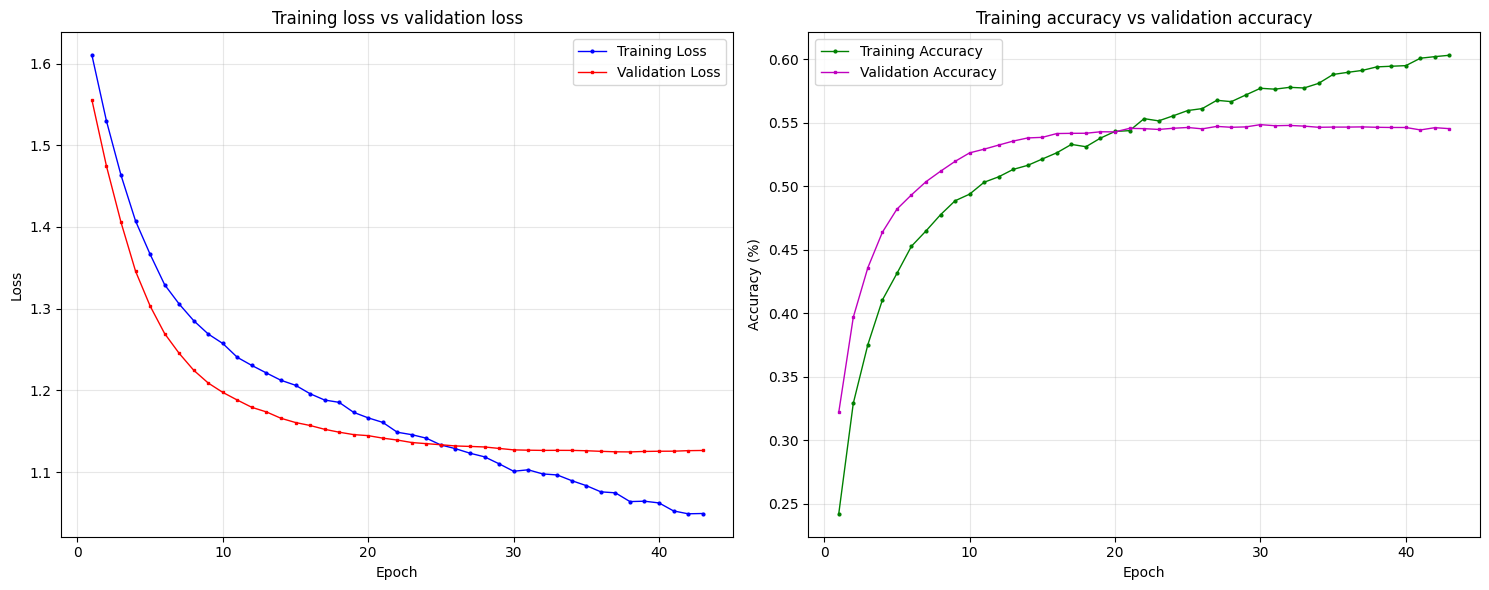

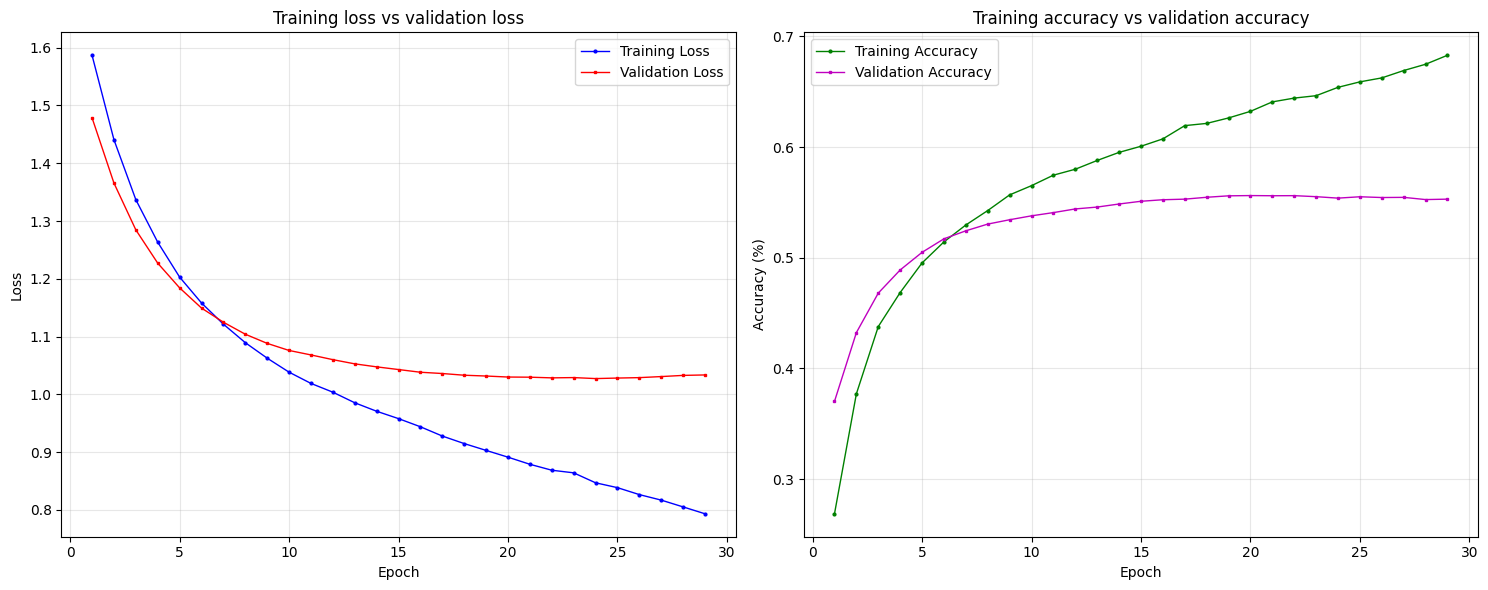

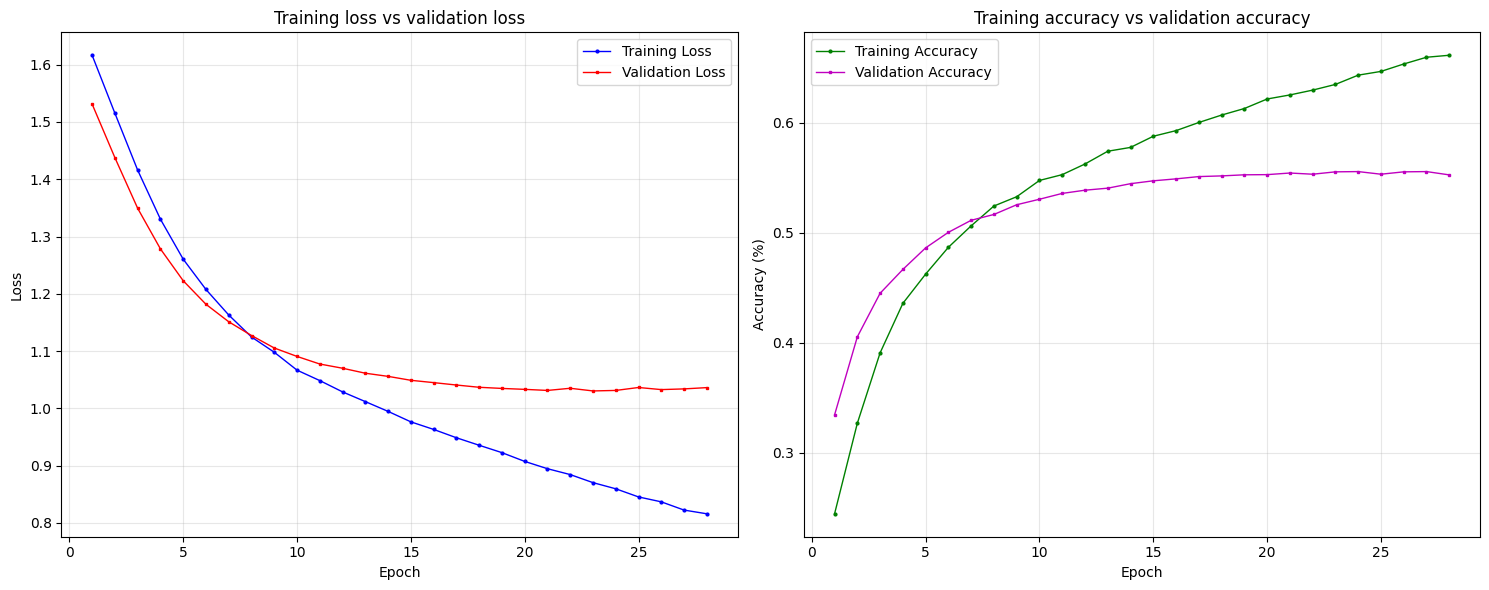

The best model is: model2


In [79]:
# Results viasualization
def create_loss_plot(train_losses,
                     val_losses,
                     train_accuracies,
                     val_accuracies):

  epochs = range(1, len(train_losses) + 1)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


  # Loss plot
  ax1.plot(epochs, train_losses, "b-", label="Training Loss", linewidth=1, marker="o", markersize=2)
  ax1.plot(epochs, val_losses, "r-", label="Validation Loss", linewidth=1, marker="s", markersize=2)

  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.set_title("Training loss vs validation loss")
  ax1.legend()
  ax1.grid(True, alpha=0.3)

  # Accuracy plot
  ax2.plot(epochs, train_accuracies, "g-", label="Training Accuracy", linewidth=1, marker="o", markersize=2)
  ax2.plot(epochs, val_accuracies, "m-", label="Validation Accuracy", linewidth=1, marker="s", markersize=2)

  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy (%)")
  ax2.set_title("Training accuracy vs validation accuracy")
  ax2.legend()
  ax2.grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

api = wandb.Api()
runs = api.runs("kacper-pt119-warsaw-university-of-technology/3DifferentNeuralNetsExperiments_v23")

metrics = ["train/loss", "val/loss", "train/accuracy", "val/accuracy"]

all_histories = {}

for run in runs:
  history = run.history(keys=metrics)
  all_histories[run.name] = history

the_best_val_loss_model = None
the_best_val_loss = float("inf")
for name, history in all_histories.items():
  if the_best_val_loss_model is None:
    the_best_val_loss_model = name
    the_best_val_loss = np.min(history["val/loss"].to_list())
  else:
    if np.min(history["val/loss"].to_list()) < the_best_val_loss:
      the_best_val_loss_model = name
      the_best_val_loss = np.min(history["val/loss"].to_list())

  train_losses = history["train/loss"].to_list()
  val_losses   = history["val/loss"].to_list()
  train_acc    = history["train/accuracy"].to_list()
  val_acc      = history["val/accuracy"].to_list()
  create_loss_plot(train_losses, val_losses, train_acc, val_acc)

print(f"The best model is: {the_best_val_loss_model}")




              precision    recall  f1-score   support

           0       0.66      0.74      0.70      3978
           1       0.50      0.46      0.48      3981
           2       0.47      0.44      0.46      3999
           3       0.48      0.45      0.46      4045
           4       0.63      0.68      0.65      3997

    accuracy                           0.55     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.55      0.55      0.55     20000



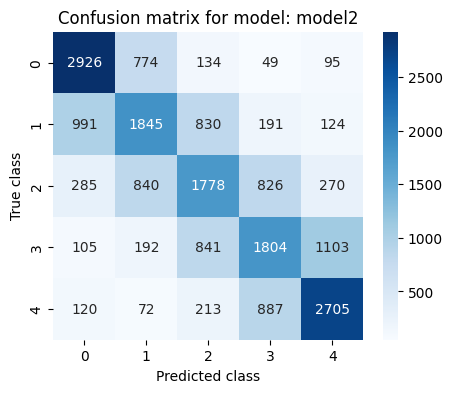

In [80]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Model evaluation
def get_data_to_eval(model, data_loader):
  model.eval()
  preds_l = []
  targets_l = []
  with torch.inference_mode():
      for inputs, targets in data_loader:
          device = next(model.parameters()).device
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          preds_l.extend(predicted.cpu().numpy())
          targets_l.extend(targets.cpu().numpy())
  return preds_l, targets_l

the_best_model = classifiers[the_best_val_loss_model]
preds, targets = get_data_to_eval(the_best_model, loaders["test"])
labels = [str(i) for i in range(0,5)]

report = classification_report(targets, preds, target_names = labels)
print(report)

# Confusion matrix
cm = confusion_matrix(targets, preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title(f"Confusion matrix for model: {the_best_val_loss_model}")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()

A function that finds and displays $k$ elements of the test set for which the model is most wrong, i.e., predicts the smallest probabilities of the true class. Softmax is a strictly increasing function, so it is enough to find elements with the smallest value of unnormalized output from the network (logit) for the true class.

In [52]:
import torch.nn.functional as F

def get_worst_predictions(model, data_loader, k=10):
    model.eval()
    device = next(model.parameters()).device
    mistakes = []

    with torch.inference_mode():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            preds = torch.argmax(logits, dim=1)

            probs = F.softmax(logits, dim=1)
            # Get probabilities for True class
            true_class_probs = probs.gather(1, targets.unsqueeze(1)).squeeze(1)

            for i in range(targets.size(0)):
                mistakes.append((true_class_probs[i].item(), inputs[i].cpu(), targets[i].item(), preds[i].item()))

    mistakes.sort(key=lambda x: x[0])
    return mistakes[:k]

the_biggest_mistakes = get_worst_predictions(the_best_model, loaders["test"])
for i, mistake in enumerate(the_biggest_mistakes):
    prob, x, target, pred = mistake
    print(f"{i+1}. True class: {target}, Predicted class: {pred}, Probability for true class: {prob:.4f}")


1. True class: 4, Predicted class: 0, Probability for true class: 0.0001
2. True class: 2, Predicted class: 4, Probability for true class: 0.0006
3. True class: 3, Predicted class: 0, Probability for true class: 0.0008
4. True class: 2, Predicted class: 0, Probability for true class: 0.0008
5. True class: 4, Predicted class: 0, Probability for true class: 0.0012
6. True class: 2, Predicted class: 0, Probability for true class: 0.0012
7. True class: 2, Predicted class: 0, Probability for true class: 0.0014
8. True class: 2, Predicted class: 0, Probability for true class: 0.0016
9. True class: 0, Predicted class: 2, Probability for true class: 0.0017
10. True class: 2, Predicted class: 4, Probability for true class: 0.0020


## Experimenting with Different TF-IDF Vectorizer Configurations

In this section, I explore various TF-IDF vectorization strategies to determine which feature extraction approach yields the best classification performance. We test different combinations of:

### Parameters Being Tested:

1. **Vocabulary Size (`vocab_size`)**: 
   - 5,000 features
   - 10,000 features
   
2. **Analyzer Type (`analyzer`)**:
   - `"word"`: Word-level tokenization (analyzes individual words)
   - `"char"`: Character-level tokenization (analyzes character sequences)
   
3. **N-gram Range (`ngram_range`)**:
   - `(1, 1)`: Unigrams only (single words)
   - `(1, 2)`: Unigrams and bigrams (single words and word pairs)
   - `(2, 3)`: Character bigrams and trigrams

### Configurations:

We train the `LargeNet` model on 6 different vectorizer configurations:
- **10_words_1gram**: 10,000 word unigrams
- **10_words_1-2gram**: 10,000 word unigrams + bigrams
- **5_words_1gram**: 5,000 word unigrams
- **5_words_1-2gram**: 5,000 word unigrams + bigrams
- **10_char_2-3gram**: 10,000 character 2-3 grams
- **5_char_2-3gram**: 5,000 character 2-3 grams

Each configuration is trained separately and logged to Weights & Biases for comparison.

In [ ]:
# Different TfidfVectorizer configs

configs = [
    {"vocab_size" : 10000,"analyzer": "word", "ngram_range": (1, 1), "name": "10_words_1gram"},
    {"vocab_size" : 10000, "analyzer": "word", "ngram_range": (1, 2), "name": "10_words_1-2gram"},
    {"vocab_size" : 5000,"analyzer": "word", "ngram_range": (1, 1), "name": "5_words_1gram"},
    {"vocab_size" : 5000, "analyzer": "word", "ngram_range": (1, 2), "name": "5_words_1-2gram"},
    {"vocab_size" : 10000, "analyzer": "char", "ngram_range": (2, 3), "name": "10_char_2-3gram"},
    {"vocab_size" : 5000, "analyzer": "char", "ngram_range": (2, 3), "name": "5_char_2-3gram"}
]
num_epochs=40

the_best_model_state = None
the_best_model_config = None
the_best_val_loss = float("inf")
for con in configs:
    vectorizer = TfidfVectorizer(
        max_features=con["vocab_size"],
        analyzer=con["analyzer"],
        ngram_range=con["ngram_range"],
        stop_words="english" if con["analyzer"] == "word" else None
    )

    train_tfidf_features = vectorizer.fit_transform(train_dataset["text"])
    val_tfidf_features = vectorizer.transform(val_dataset["text"])
    test_tfidf_features = vectorizer.transform(test_dataset["text"])

    datasets = {
    "train": make_dataset(train_tfidf_features, train_dataset["label"]),
    "val": make_dataset(val_tfidf_features, val_dataset["label"]),
    "test": make_dataset(test_tfidf_features, test_dataset["label"])
    }

    train_loader = DataLoader(datasets["train"], shuffle=True, batch_size=256)
    val_loader = DataLoader(datasets["val"], shuffle=False, batch_size=256)
    test_loader = DataLoader(datasets["test"], shuffle=False, batch_size=256)

    loaders = {"train" : train_loader,
               "val": val_loader,
               "test": test_loader}

    model = MediumNet(con["vocab_size"], 5)
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=2e-3, weight_decay=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    run = wandb.init(
        project="DifferentConfigsForVectorizer_v2",
        name=con["name"],
        config={
            "model": con["name"],
            "vocab_size": con["vocab_size"],
            "analyzer": con["analyzer"],
            "ngram": con["ngram_range"],
            "num_classes": 5,
            "optimizer": "SGD",
            "lr": 2e-3,
            "weight_decay": 1e-4,
            "scheduler": "StepLR",
            "step": 10,
            "gamma": 0.9,
            "num_epochs": num_epochs
        }
    )
    train(model, loaders, criterion, optimizer, lr_scheduler, num_epochs, device)
    
    # Evaluate on validation set to get final validation loss
    model.eval()
    metric_loss = torchmetrics.aggregation.MeanMetric().to(device)
    with torch.inference_mode():
        for X_batch, target in loaders["val"]:
            X_batch, target = X_batch.to(device), target.to(device)
            logits = model(X_batch)
            loss = criterion(logits, target)
            metric_loss(loss)
    
    final_val_loss = metric_loss.compute().item()
    
    if final_val_loss < the_best_val_loss:
        the_best_val_loss = final_val_loss
        the_best_model_config = con.copy()
        print(f"New best model: {con['name']} with val_loss: {final_val_loss:.4f}")
    
    run.finish()

    del train_tfidf_features, val_tfidf_features, test_tfidf_features
    del datasets, train_loader, val_loader, test_loader, loaders
    del model, optimizer, lr_scheduler, metric_loss
    del vectorizer
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\n{'='*60}")
print(f"BEST MODEL: {the_best_model_config['name']}")
print(f"Best validation loss: {the_best_val_loss:.4f}")
print(f"Configuration: {the_best_model_config}")
print(f"{'='*60}\n")

100%|██████████| 204/204 [00:02<00:00, 77.45it/s]


(Epoch 1/[train]) Loss:	1.559   Accuracy: 0.294   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 102.79it/s]


(Epoch 1/[val]) Loss:	1.427   Accuracy: 0.407   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 57.95it/s]


(Epoch 2/[train]) Loss:	1.372   Accuracy: 0.424   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 82.65it/s]


(Epoch 2/[val]) Loss:	1.302   Accuracy: 0.467   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 60.15it/s]


(Epoch 3/[train]) Loss:	1.260   Accuracy: 0.482   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 83.49it/s]


(Epoch 3/[val]) Loss:	1.222   Accuracy: 0.496   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 57.35it/s]


(Epoch 4/[train]) Loss:	1.182   Accuracy: 0.515   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 69.28it/s]


(Epoch 4/[val]) Loss:	1.168   Accuracy: 0.512   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 52.00it/s]


(Epoch 5/[train]) Loss:	1.122   Accuracy: 0.542   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 78.55it/s]


(Epoch 5/[val]) Loss:	1.132   Accuracy: 0.524   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 59.55it/s]


(Epoch 6/[train]) Loss:	1.076   Accuracy: 0.561   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 76.95it/s]


(Epoch 6/[val]) Loss:	1.104   Accuracy: 0.529   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 59.48it/s]


(Epoch 7/[train]) Loss:	1.036   Accuracy: 0.578   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 80.41it/s]


(Epoch 7/[val]) Loss:	1.083   Accuracy: 0.538   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 59.95it/s]


(Epoch 8/[train]) Loss:	1.002   Accuracy: 0.595   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 78.44it/s]


(Epoch 8/[val]) Loss:	1.067   Accuracy: 0.542   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 54.63it/s]


(Epoch 9/[train]) Loss:	0.973   Accuracy: 0.606   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 79.78it/s]


(Epoch 9/[val]) Loss:	1.056   Accuracy: 0.547   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 58.38it/s]


(Epoch 10/[train]) Loss:	0.944   Accuracy: 0.623   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 81.31it/s]


(Epoch 10/[val]) Loss:	1.046   Accuracy: 0.550   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 59.71it/s]


(Epoch 11/[train]) Loss:	0.915   Accuracy: 0.632   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 80.18it/s]


(Epoch 11/[val]) Loss:	1.040   Accuracy: 0.551   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 54.98it/s]


(Epoch 12/[train]) Loss:	0.896   Accuracy: 0.645   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 79.42it/s]


(Epoch 12/[val]) Loss:	1.036   Accuracy: 0.554   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 57.66it/s]


(Epoch 13/[train]) Loss:	0.871   Accuracy: 0.654   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 81.55it/s]


(Epoch 13/[val]) Loss:	1.033   Accuracy: 0.556   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 57.32it/s]


(Epoch 14/[train]) Loss:	0.849   Accuracy: 0.666   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 73.50it/s]


(Epoch 14/[val]) Loss:	1.030   Accuracy: 0.556   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 55.30it/s]


(Epoch 15/[train]) Loss:	0.829   Accuracy: 0.674   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 73.56it/s]


(Epoch 15/[val]) Loss:	1.029   Accuracy: 0.558   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 58.36it/s]


(Epoch 16/[train]) Loss:	0.806   Accuracy: 0.685   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 80.91it/s]


(Epoch 16/[val]) Loss:	1.029   Accuracy: 0.558   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 58.91it/s]


(Epoch 17/[train]) Loss:	0.787   Accuracy: 0.696   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 80.83it/s]


(Epoch 17/[val]) Loss:	1.029   Accuracy: 0.557   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 59.44it/s]


(Epoch 18/[train]) Loss:	0.763   Accuracy: 0.708   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 78.40it/s]


(Epoch 18/[val]) Loss:	1.032   Accuracy: 0.556   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 57.26it/s]


(Epoch 19/[train]) Loss:	0.743   Accuracy: 0.719   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 79.01it/s]


(Epoch 19/[val]) Loss:	1.035   Accuracy: 0.555   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 58.72it/s]


(Epoch 20/[train]) Loss:	0.721   Accuracy: 0.730   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 69.30it/s]


(Epoch 20/[val]) Loss:	1.036   Accuracy: 0.556   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 56.22it/s]


(Epoch 21/[train]) Loss:	0.700   Accuracy: 0.738   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 79.04it/s]


(Epoch 21/[val]) Loss:	1.040   Accuracy: 0.554   lr: 0.0016200000000000001
--------------------Early stopping--------------------
New best model: 10_words_1gram with val_loss: 1.0289


train/accuracy,▁▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/loss,█▆▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/lr,██████████▄▄▄▄▄▄▄▄▄▄▁
val/accuracy,▁▄▅▆▆▇▇▇▇████████████
val/loss,█▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/lr,██████████▄▄▄▄▄▄▄▄▄▄▁
train/accuracy,0.7379
train/loss,0.70042
train/lr,0.00162
val/accuracy,0.55423
val/loss,1.04022


100%|██████████| 204/204 [00:03<00:00, 54.40it/s]


(Epoch 1/[train]) Loss:	1.560   Accuracy: 0.286   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 81.02it/s]


(Epoch 1/[val]) Loss:	1.436   Accuracy: 0.400   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 56.99it/s]


(Epoch 2/[train]) Loss:	1.380   Accuracy: 0.417   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 76.30it/s]


(Epoch 2/[val]) Loss:	1.311   Accuracy: 0.461   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 61.05it/s]


(Epoch 3/[train]) Loss:	1.264   Accuracy: 0.477   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 78.16it/s]


(Epoch 3/[val]) Loss:	1.230   Accuracy: 0.491   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 54.75it/s]


(Epoch 4/[train]) Loss:	1.180   Accuracy: 0.514   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 74.91it/s]


(Epoch 4/[val]) Loss:	1.175   Accuracy: 0.513   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 57.65it/s]


(Epoch 5/[train]) Loss:	1.117   Accuracy: 0.544   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 69.52it/s]


(Epoch 5/[val]) Loss:	1.133   Accuracy: 0.523   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 58.72it/s]


(Epoch 6/[train]) Loss:	1.067   Accuracy: 0.566   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 79.26it/s]


(Epoch 6/[val]) Loss:	1.102   Accuracy: 0.533   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 54.58it/s]


(Epoch 7/[train]) Loss:	1.025   Accuracy: 0.584   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 73.62it/s]


(Epoch 7/[val]) Loss:	1.081   Accuracy: 0.541   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 57.07it/s]


(Epoch 8/[train]) Loss:	0.989   Accuracy: 0.599   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 75.61it/s]


(Epoch 8/[val]) Loss:	1.065   Accuracy: 0.546   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 57.42it/s]


(Epoch 9/[train]) Loss:	0.956   Accuracy: 0.617   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 75.35it/s]


(Epoch 9/[val]) Loss:	1.051   Accuracy: 0.550   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 58.52it/s]


(Epoch 10/[train]) Loss:	0.925   Accuracy: 0.629   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 76.62it/s]


(Epoch 10/[val]) Loss:	1.041   Accuracy: 0.554   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 55.37it/s]


(Epoch 11/[train]) Loss:	0.896   Accuracy: 0.644   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 76.33it/s]


(Epoch 11/[val]) Loss:	1.034   Accuracy: 0.557   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 58.74it/s]


(Epoch 12/[train]) Loss:	0.872   Accuracy: 0.652   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 74.28it/s]


(Epoch 12/[val]) Loss:	1.029   Accuracy: 0.560   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 57.56it/s]


(Epoch 13/[train]) Loss:	0.848   Accuracy: 0.666   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 78.43it/s]


(Epoch 13/[val]) Loss:	1.026   Accuracy: 0.558   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 59.07it/s]


(Epoch 14/[train]) Loss:	0.825   Accuracy: 0.676   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 82.42it/s]


(Epoch 14/[val]) Loss:	1.023   Accuracy: 0.559   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 55.78it/s]


(Epoch 15/[train]) Loss:	0.800   Accuracy: 0.688   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 69.03it/s]


(Epoch 15/[val]) Loss:	1.022   Accuracy: 0.560   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 53.62it/s]


(Epoch 16/[train]) Loss:	0.778   Accuracy: 0.700   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 79.28it/s]


(Epoch 16/[val]) Loss:	1.022   Accuracy: 0.562   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 59.05it/s]


(Epoch 17/[train]) Loss:	0.755   Accuracy: 0.710   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 79.29it/s]


(Epoch 17/[val]) Loss:	1.022   Accuracy: 0.561   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 59.41it/s]


(Epoch 18/[train]) Loss:	0.732   Accuracy: 0.722   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 79.27it/s]


(Epoch 18/[val]) Loss:	1.025   Accuracy: 0.562   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 58.81it/s]


(Epoch 19/[train]) Loss:	0.707   Accuracy: 0.735   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 53.11it/s]


(Epoch 19/[val]) Loss:	1.027   Accuracy: 0.562   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 58.28it/s]


(Epoch 20/[train]) Loss:	0.686   Accuracy: 0.746   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 76.07it/s]


(Epoch 20/[val]) Loss:	1.030   Accuracy: 0.562   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 59.65it/s]


(Epoch 21/[train]) Loss:	0.661   Accuracy: 0.758   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 69.65it/s]


(Epoch 21/[val]) Loss:	1.034   Accuracy: 0.562   lr: 0.0016200000000000001
--------------------Early stopping--------------------
New best model: 10_words_1-2gram with val_loss: 1.0217


train/accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
train/lr,██████████▄▄▄▄▄▄▄▄▄▄▁
val/accuracy,▁▄▅▆▆▇▇▇▇████████████
val/loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/lr,██████████▄▄▄▄▄▄▄▄▄▄▁
train/accuracy,0.7585
train/loss,0.66108
train/lr,0.00162
val/accuracy,0.56154
val/loss,1.03395


100%|██████████| 204/204 [00:02<00:00, 100.93it/s]


(Epoch 1/[train]) Loss:	1.601   Accuracy: 0.269   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 130.58it/s]


(Epoch 1/[val]) Loss:	1.497   Accuracy: 0.361   lr: 0.002


100%|██████████| 204/204 [00:01<00:00, 105.75it/s]


(Epoch 2/[train]) Loss:	1.461   Accuracy: 0.372   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 143.23it/s]


(Epoch 2/[val]) Loss:	1.388   Accuracy: 0.431   lr: 0.002


100%|██████████| 204/204 [00:01<00:00, 106.70it/s]


(Epoch 3/[train]) Loss:	1.356   Accuracy: 0.431   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 141.55it/s]


(Epoch 3/[val]) Loss:	1.305   Accuracy: 0.467   lr: 0.002


100%|██████████| 204/204 [00:01<00:00, 102.71it/s]


(Epoch 4/[train]) Loss:	1.276   Accuracy: 0.468   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 80.97it/s]


(Epoch 4/[val]) Loss:	1.241   Accuracy: 0.488   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 82.44it/s]


(Epoch 5/[train]) Loss:	1.214   Accuracy: 0.495   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 108.28it/s]


(Epoch 5/[val]) Loss:	1.193   Accuracy: 0.506   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 77.91it/s]


(Epoch 6/[train]) Loss:	1.163   Accuracy: 0.518   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 106.20it/s]


(Epoch 6/[val]) Loss:	1.159   Accuracy: 0.517   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 82.27it/s]


(Epoch 7/[train]) Loss:	1.126   Accuracy: 0.531   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 115.65it/s]


(Epoch 7/[val]) Loss:	1.130   Accuracy: 0.525   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 84.50it/s]


(Epoch 8/[train]) Loss:	1.093   Accuracy: 0.544   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 115.08it/s]


(Epoch 8/[val]) Loss:	1.110   Accuracy: 0.528   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 80.43it/s]


(Epoch 9/[train]) Loss:	1.066   Accuracy: 0.554   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 108.15it/s]


(Epoch 9/[val]) Loss:	1.094   Accuracy: 0.533   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 79.81it/s]


(Epoch 10/[train]) Loss:	1.041   Accuracy: 0.565   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 106.14it/s]


(Epoch 10/[val]) Loss:	1.079   Accuracy: 0.537   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 81.97it/s]


(Epoch 11/[train]) Loss:	1.021   Accuracy: 0.574   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 115.52it/s]


(Epoch 11/[val]) Loss:	1.069   Accuracy: 0.540   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 86.09it/s]


(Epoch 12/[train]) Loss:	1.004   Accuracy: 0.580   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 114.76it/s]


(Epoch 12/[val]) Loss:	1.061   Accuracy: 0.542   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 81.29it/s]


(Epoch 13/[train]) Loss:	0.987   Accuracy: 0.589   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 111.28it/s]


(Epoch 13/[val]) Loss:	1.054   Accuracy: 0.545   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 75.10it/s]


(Epoch 14/[train]) Loss:	0.972   Accuracy: 0.595   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 106.45it/s]


(Epoch 14/[val]) Loss:	1.049   Accuracy: 0.545   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 81.87it/s]


(Epoch 15/[train]) Loss:	0.957   Accuracy: 0.605   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 109.28it/s]


(Epoch 15/[val]) Loss:	1.044   Accuracy: 0.546   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 75.59it/s]


(Epoch 16/[train]) Loss:	0.940   Accuracy: 0.610   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 106.86it/s]


(Epoch 16/[val]) Loss:	1.039   Accuracy: 0.548   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 81.29it/s]


(Epoch 17/[train]) Loss:	0.927   Accuracy: 0.617   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 102.94it/s]


(Epoch 17/[val]) Loss:	1.036   Accuracy: 0.550   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 80.43it/s]


(Epoch 18/[train]) Loss:	0.913   Accuracy: 0.622   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 99.74it/s] 


(Epoch 18/[val]) Loss:	1.034   Accuracy: 0.550   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 81.95it/s]


(Epoch 19/[train]) Loss:	0.903   Accuracy: 0.628   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 115.12it/s]


(Epoch 19/[val]) Loss:	1.033   Accuracy: 0.550   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 84.05it/s]


(Epoch 20/[train]) Loss:	0.886   Accuracy: 0.635   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 114.49it/s]


(Epoch 20/[val]) Loss:	1.030   Accuracy: 0.551   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 81.93it/s]


(Epoch 21/[train]) Loss:	0.875   Accuracy: 0.642   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 108.32it/s]


(Epoch 21/[val]) Loss:	1.030   Accuracy: 0.550   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 83.34it/s]


(Epoch 22/[train]) Loss:	0.865   Accuracy: 0.645   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 112.29it/s]


(Epoch 22/[val]) Loss:	1.029   Accuracy: 0.552   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 78.58it/s]


(Epoch 23/[train]) Loss:	0.856   Accuracy: 0.650   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 91.01it/s] 


(Epoch 23/[val]) Loss:	1.029   Accuracy: 0.553   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 82.36it/s]


(Epoch 24/[train]) Loss:	0.842   Accuracy: 0.656   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 99.98it/s] 


(Epoch 24/[val]) Loss:	1.029   Accuracy: 0.552   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 83.53it/s]


(Epoch 25/[train]) Loss:	0.833   Accuracy: 0.660   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 80.25it/s]


(Epoch 25/[val]) Loss:	1.029   Accuracy: 0.552   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 82.24it/s]


(Epoch 26/[train]) Loss:	0.822   Accuracy: 0.667   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 104.67it/s]


(Epoch 26/[val]) Loss:	1.029   Accuracy: 0.551   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 81.03it/s]


(Epoch 27/[train]) Loss:	0.811   Accuracy: 0.673   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 109.11it/s]


(Epoch 27/[val]) Loss:	1.031   Accuracy: 0.551   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 83.15it/s]


(Epoch 28/[train]) Loss:	0.802   Accuracy: 0.677   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 103.33it/s]


(Epoch 28/[val]) Loss:	1.033   Accuracy: 0.550   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 78.64it/s]


(Epoch 29/[train]) Loss:	0.789   Accuracy: 0.683   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 105.77it/s]


(Epoch 29/[val]) Loss:	1.033   Accuracy: 0.549   lr: 0.0016200000000000001
--------------------Early stopping--------------------


train/accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
train/loss,█▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train/lr,██████████▄▄▄▄▄▄▄▄▄▄▁▁▁▁▁▁▁▁▁
val/accuracy,▁▄▅▆▆▇▇▇▇▇███████████████████
val/loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/lr,██████████▄▄▄▄▄▄▄▄▄▄▁▁▁▁▁▁▁▁▁
train/accuracy,0.68331
train/loss,0.7895
train/lr,0.00162
val/accuracy,0.54931
val/loss,1.0334


100%|██████████| 204/204 [00:02<00:00, 84.00it/s]


(Epoch 1/[train]) Loss:	1.595   Accuracy: 0.266   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 113.90it/s]


(Epoch 1/[val]) Loss:	1.486   Accuracy: 0.363   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 86.23it/s]


(Epoch 2/[train]) Loss:	1.448   Accuracy: 0.373   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 103.25it/s]


(Epoch 2/[val]) Loss:	1.372   Accuracy: 0.438   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 83.03it/s]


(Epoch 3/[train]) Loss:	1.342   Accuracy: 0.432   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 75.30it/s] 


(Epoch 3/[val]) Loss:	1.285   Accuracy: 0.475   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 83.97it/s]


(Epoch 4/[train]) Loss:	1.263   Accuracy: 0.472   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 111.27it/s]


(Epoch 4/[val]) Loss:	1.225   Accuracy: 0.492   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 81.39it/s]


(Epoch 5/[train]) Loss:	1.201   Accuracy: 0.498   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 115.70it/s]


(Epoch 5/[val]) Loss:	1.179   Accuracy: 0.507   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 86.66it/s]


(Epoch 6/[train]) Loss:	1.153   Accuracy: 0.518   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 114.36it/s]


(Epoch 6/[val]) Loss:	1.146   Accuracy: 0.518   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 86.41it/s]


(Epoch 7/[train]) Loss:	1.113   Accuracy: 0.535   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 115.56it/s]


(Epoch 7/[val]) Loss:	1.117   Accuracy: 0.528   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 85.76it/s]


(Epoch 8/[train]) Loss:	1.082   Accuracy: 0.549   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 113.38it/s]


(Epoch 8/[val]) Loss:	1.096   Accuracy: 0.533   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 84.27it/s]


(Epoch 9/[train]) Loss:	1.056   Accuracy: 0.557   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 110.94it/s]


(Epoch 9/[val]) Loss:	1.080   Accuracy: 0.538   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 81.57it/s]


(Epoch 10/[train]) Loss:	1.033   Accuracy: 0.567   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 112.34it/s]


(Epoch 10/[val]) Loss:	1.067   Accuracy: 0.544   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 83.94it/s]


(Epoch 11/[train]) Loss:	1.008   Accuracy: 0.580   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 110.06it/s]


(Epoch 11/[val]) Loss:	1.057   Accuracy: 0.546   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 83.48it/s]


(Epoch 12/[train]) Loss:	0.995   Accuracy: 0.585   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 112.09it/s]


(Epoch 12/[val]) Loss:	1.049   Accuracy: 0.548   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 78.82it/s]


(Epoch 13/[train]) Loss:	0.977   Accuracy: 0.592   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 113.43it/s]


(Epoch 13/[val]) Loss:	1.041   Accuracy: 0.554   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 81.95it/s]


(Epoch 14/[train]) Loss:	0.961   Accuracy: 0.600   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 108.29it/s]


(Epoch 14/[val]) Loss:	1.036   Accuracy: 0.553   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 85.02it/s]


(Epoch 15/[train]) Loss:	0.947   Accuracy: 0.609   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 89.39it/s]


(Epoch 15/[val]) Loss:	1.031   Accuracy: 0.557   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 81.66it/s]


(Epoch 16/[train]) Loss:	0.933   Accuracy: 0.611   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 113.44it/s]


(Epoch 16/[val]) Loss:	1.027   Accuracy: 0.558   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 77.47it/s]


(Epoch 17/[train]) Loss:	0.919   Accuracy: 0.619   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 108.07it/s]


(Epoch 17/[val]) Loss:	1.024   Accuracy: 0.561   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 83.32it/s]


(Epoch 18/[train]) Loss:	0.906   Accuracy: 0.626   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 113.88it/s]


(Epoch 18/[val]) Loss:	1.020   Accuracy: 0.560   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 85.14it/s]


(Epoch 19/[train]) Loss:	0.891   Accuracy: 0.631   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 114.31it/s]


(Epoch 19/[val]) Loss:	1.019   Accuracy: 0.560   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 84.19it/s]


(Epoch 20/[train]) Loss:	0.879   Accuracy: 0.637   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 108.84it/s]


(Epoch 20/[val]) Loss:	1.017   Accuracy: 0.563   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 81.58it/s]


(Epoch 21/[train]) Loss:	0.868   Accuracy: 0.644   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 114.79it/s]


(Epoch 21/[val]) Loss:	1.016   Accuracy: 0.563   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 85.27it/s]


(Epoch 22/[train]) Loss:	0.853   Accuracy: 0.651   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 84.93it/s]


(Epoch 22/[val]) Loss:	1.016   Accuracy: 0.562   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 80.88it/s]


(Epoch 23/[train]) Loss:	0.843   Accuracy: 0.657   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 107.16it/s]


(Epoch 23/[val]) Loss:	1.016   Accuracy: 0.560   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 85.73it/s]


(Epoch 24/[train]) Loss:	0.834   Accuracy: 0.658   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 112.40it/s]


(Epoch 24/[val]) Loss:	1.018   Accuracy: 0.558   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 84.95it/s]


(Epoch 25/[train]) Loss:	0.821   Accuracy: 0.668   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 109.98it/s]


(Epoch 25/[val]) Loss:	1.016   Accuracy: 0.564   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 86.06it/s]


(Epoch 26/[train]) Loss:	0.813   Accuracy: 0.669   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 113.63it/s]


(Epoch 26/[val]) Loss:	1.016   Accuracy: 0.562   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 86.80it/s]


(Epoch 27/[train]) Loss:	0.802   Accuracy: 0.674   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 113.50it/s]


(Epoch 27/[val]) Loss:	1.019   Accuracy: 0.559   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 84.08it/s]


(Epoch 28/[train]) Loss:	0.790   Accuracy: 0.680   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 111.19it/s]


(Epoch 28/[val]) Loss:	1.018   Accuracy: 0.562   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 84.51it/s]


(Epoch 29/[train]) Loss:	0.781   Accuracy: 0.686   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 97.26it/s]


(Epoch 29/[val]) Loss:	1.020   Accuracy: 0.562   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 78.63it/s]


(Epoch 30/[train]) Loss:	0.768   Accuracy: 0.692   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 103.01it/s]


(Epoch 30/[val]) Loss:	1.021   Accuracy: 0.562   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 95.32it/s] 


(Epoch 31/[train]) Loss:	0.754   Accuracy: 0.698   lr: 0.001458


100%|██████████| 51/51 [00:00<00:00, 105.92it/s]


(Epoch 31/[val]) Loss:	1.023   Accuracy: 0.561   lr: 0.001458
--------------------Early stopping--------------------
New best model: 5_words_1-2gram with val_loss: 1.0161


train/accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
train/loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train/lr,██████████▅▅▅▅▅▅▅▅▅▅▃▃▃▃▃▃▃▃▃▃▁
val/accuracy,▁▄▅▆▆▆▇▇▇▇▇▇███████████████████
val/loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/lr,██████████▅▅▅▅▅▅▅▅▅▅▃▃▃▃▃▃▃▃▃▃▁
train/accuracy,0.69773
train/loss,0.75441
train/lr,0.00146
val/accuracy,0.56123
val/loss,1.02331


100%|██████████| 204/204 [00:02<00:00, 76.71it/s]


(Epoch 1/[train]) Loss:	1.478   Accuracy: 0.348   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 97.65it/s] 


(Epoch 1/[val]) Loss:	1.330   Accuracy: 0.450   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 57.10it/s]


(Epoch 2/[train]) Loss:	1.292   Accuracy: 0.456   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 73.65it/s]


(Epoch 2/[val]) Loss:	1.225   Accuracy: 0.489   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 57.75it/s]


(Epoch 3/[train]) Loss:	1.199   Accuracy: 0.501   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 77.55it/s]


(Epoch 3/[val]) Loss:	1.172   Accuracy: 0.506   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 59.72it/s]


(Epoch 4/[train]) Loss:	1.136   Accuracy: 0.531   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 80.30it/s]


(Epoch 4/[val]) Loss:	1.127   Accuracy: 0.521   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 59.52it/s]


(Epoch 5/[train]) Loss:	1.092   Accuracy: 0.547   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 73.56it/s]


(Epoch 5/[val]) Loss:	1.099   Accuracy: 0.532   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 59.48it/s]


(Epoch 6/[train]) Loss:	1.055   Accuracy: 0.564   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 79.28it/s]


(Epoch 6/[val]) Loss:	1.075   Accuracy: 0.539   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 56.18it/s]


(Epoch 7/[train]) Loss:	1.022   Accuracy: 0.579   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 77.32it/s]


(Epoch 7/[val]) Loss:	1.059   Accuracy: 0.547   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 59.72it/s]


(Epoch 8/[train]) Loss:	0.994   Accuracy: 0.594   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 78.41it/s]


(Epoch 8/[val]) Loss:	1.046   Accuracy: 0.549   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 56.27it/s]


(Epoch 9/[train]) Loss:	0.969   Accuracy: 0.602   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 78.66it/s]


(Epoch 9/[val]) Loss:	1.037   Accuracy: 0.557   lr: 0.002


100%|██████████| 204/204 [00:04<00:00, 49.35it/s]


(Epoch 10/[train]) Loss:	0.945   Accuracy: 0.617   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 59.80it/s]


(Epoch 10/[val]) Loss:	1.028   Accuracy: 0.555   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 57.58it/s]


(Epoch 11/[train]) Loss:	0.920   Accuracy: 0.627   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 78.79it/s]


(Epoch 11/[val]) Loss:	1.023   Accuracy: 0.556   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 59.04it/s]


(Epoch 12/[train]) Loss:	0.902   Accuracy: 0.636   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 79.61it/s]


(Epoch 12/[val]) Loss:	1.018   Accuracy: 0.560   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 58.86it/s]


(Epoch 13/[train]) Loss:	0.883   Accuracy: 0.643   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 75.30it/s]


(Epoch 13/[val]) Loss:	1.021   Accuracy: 0.562   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 58.66it/s]


(Epoch 14/[train]) Loss:	0.867   Accuracy: 0.652   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 81.05it/s]


(Epoch 14/[val]) Loss:	1.009   Accuracy: 0.565   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 56.80it/s]


(Epoch 15/[train]) Loss:	0.847   Accuracy: 0.663   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 77.60it/s]


(Epoch 15/[val]) Loss:	1.006   Accuracy: 0.563   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 59.29it/s]


(Epoch 16/[train]) Loss:	0.829   Accuracy: 0.671   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 82.45it/s]


(Epoch 16/[val]) Loss:	1.006   Accuracy: 0.562   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 58.57it/s]


(Epoch 17/[train]) Loss:	0.808   Accuracy: 0.682   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 78.19it/s]


(Epoch 17/[val]) Loss:	1.007   Accuracy: 0.562   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 59.09it/s]


(Epoch 18/[train]) Loss:	0.794   Accuracy: 0.686   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 79.05it/s]


(Epoch 18/[val]) Loss:	1.010   Accuracy: 0.561   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 56.32it/s]


(Epoch 19/[train]) Loss:	0.774   Accuracy: 0.697   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:01<00:00, 41.71it/s]


(Epoch 19/[val]) Loss:	1.009   Accuracy: 0.562   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 55.77it/s]


(Epoch 20/[train]) Loss:	0.761   Accuracy: 0.702   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 75.16it/s]


(Epoch 20/[val]) Loss:	1.016   Accuracy: 0.560   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:03<00:00, 56.93it/s]


(Epoch 21/[train]) Loss:	0.740   Accuracy: 0.715   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 84.13it/s]


(Epoch 21/[val]) Loss:	1.014   Accuracy: 0.560   lr: 0.0016200000000000001
--------------------Early stopping--------------------
New best model: 10_char_2-3gram with val_loss: 1.0055


train/accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/lr,██████████▄▄▄▄▄▄▄▄▄▄▁
val/accuracy,▁▃▄▅▆▆▇▇█▇▇██████████
val/loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val/lr,██████████▄▄▄▄▄▄▄▄▄▄▁
train/accuracy,0.71544
train/loss,0.74005
train/lr,0.00162
val/accuracy,0.55977
val/loss,1.0137


100%|██████████| 204/204 [00:02<00:00, 73.90it/s]


(Epoch 1/[train]) Loss:	1.555   Accuracy: 0.291   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 105.22it/s]


(Epoch 1/[val]) Loss:	1.433   Accuracy: 0.391   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 74.59it/s]


(Epoch 2/[train]) Loss:	1.395   Accuracy: 0.403   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 97.00it/s]


(Epoch 2/[val]) Loss:	1.322   Accuracy: 0.449   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 82.81it/s]


(Epoch 3/[train]) Loss:	1.302   Accuracy: 0.448   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 113.15it/s]


(Epoch 3/[val]) Loss:	1.251   Accuracy: 0.480   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 85.04it/s]


(Epoch 4/[train]) Loss:	1.233   Accuracy: 0.482   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 114.38it/s]


(Epoch 4/[val]) Loss:	1.201   Accuracy: 0.497   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 83.65it/s]


(Epoch 5/[train]) Loss:	1.183   Accuracy: 0.502   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 105.99it/s]


(Epoch 5/[val]) Loss:	1.162   Accuracy: 0.513   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 84.84it/s]


(Epoch 6/[train]) Loss:	1.146   Accuracy: 0.512   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 107.52it/s]


(Epoch 6/[val]) Loss:	1.133   Accuracy: 0.518   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 71.71it/s]


(Epoch 7/[train]) Loss:	1.111   Accuracy: 0.532   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 138.35it/s]


(Epoch 7/[val]) Loss:	1.109   Accuracy: 0.526   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 78.75it/s]


(Epoch 8/[train]) Loss:	1.085   Accuracy: 0.540   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 111.98it/s]


(Epoch 8/[val]) Loss:	1.093   Accuracy: 0.531   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 80.63it/s]


(Epoch 9/[train]) Loss:	1.061   Accuracy: 0.554   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 96.47it/s]


(Epoch 9/[val]) Loss:	1.075   Accuracy: 0.538   lr: 0.002


100%|██████████| 204/204 [00:02<00:00, 83.09it/s]


(Epoch 10/[train]) Loss:	1.037   Accuracy: 0.562   lr: 0.002


100%|██████████| 51/51 [00:00<00:00, 103.33it/s]


(Epoch 10/[val]) Loss:	1.062   Accuracy: 0.543   lr: 0.002


100%|██████████| 204/204 [00:03<00:00, 59.59it/s]


(Epoch 11/[train]) Loss:	1.020   Accuracy: 0.572   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 106.38it/s]


(Epoch 11/[val]) Loss:	1.052   Accuracy: 0.544   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 78.82it/s]


(Epoch 12/[train]) Loss:	1.004   Accuracy: 0.577   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 109.59it/s]


(Epoch 12/[val]) Loss:	1.045   Accuracy: 0.548   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 87.52it/s]


(Epoch 13/[train]) Loss:	0.990   Accuracy: 0.586   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 113.88it/s]


(Epoch 13/[val]) Loss:	1.042   Accuracy: 0.549   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 88.38it/s]


(Epoch 14/[train]) Loss:	0.978   Accuracy: 0.589   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 114.99it/s]


(Epoch 14/[val]) Loss:	1.032   Accuracy: 0.554   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 91.32it/s]


(Epoch 15/[train]) Loss:	0.966   Accuracy: 0.596   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 124.06it/s]


(Epoch 15/[val]) Loss:	1.026   Accuracy: 0.557   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 96.14it/s]


(Epoch 16/[train]) Loss:	0.954   Accuracy: 0.601   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 124.88it/s]


(Epoch 16/[val]) Loss:	1.021   Accuracy: 0.559   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 89.04it/s]


(Epoch 17/[train]) Loss:	0.939   Accuracy: 0.607   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 127.75it/s]


(Epoch 17/[val]) Loss:	1.018   Accuracy: 0.560   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 95.62it/s]


(Epoch 18/[train]) Loss:	0.928   Accuracy: 0.613   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 127.67it/s]


(Epoch 18/[val]) Loss:	1.016   Accuracy: 0.561   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 93.85it/s]


(Epoch 19/[train]) Loss:	0.918   Accuracy: 0.617   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 125.70it/s]


(Epoch 19/[val]) Loss:	1.011   Accuracy: 0.563   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 95.66it/s]


(Epoch 20/[train]) Loss:	0.905   Accuracy: 0.625   lr: 0.0018000000000000002


100%|██████████| 51/51 [00:00<00:00, 131.30it/s]


(Epoch 20/[val]) Loss:	1.013   Accuracy: 0.560   lr: 0.0018000000000000002


100%|██████████| 204/204 [00:02<00:00, 95.70it/s]


(Epoch 21/[train]) Loss:	0.896   Accuracy: 0.627   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 127.90it/s]


(Epoch 21/[val]) Loss:	1.007   Accuracy: 0.566   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 96.13it/s]


(Epoch 22/[train]) Loss:	0.885   Accuracy: 0.633   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 126.53it/s]


(Epoch 22/[val]) Loss:	1.005   Accuracy: 0.566   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 93.47it/s]


(Epoch 23/[train]) Loss:	0.876   Accuracy: 0.637   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 127.81it/s]


(Epoch 23/[val]) Loss:	1.004   Accuracy: 0.565   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 94.71it/s]


(Epoch 24/[train]) Loss:	0.867   Accuracy: 0.641   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 129.03it/s]


(Epoch 24/[val]) Loss:	1.004   Accuracy: 0.565   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 92.99it/s]


(Epoch 25/[train]) Loss:	0.857   Accuracy: 0.648   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 124.80it/s]


(Epoch 25/[val]) Loss:	1.011   Accuracy: 0.557   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 93.99it/s]


(Epoch 26/[train]) Loss:	0.849   Accuracy: 0.648   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 128.59it/s]


(Epoch 26/[val]) Loss:	1.001   Accuracy: 0.566   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 88.93it/s]


(Epoch 27/[train]) Loss:	0.841   Accuracy: 0.655   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 119.52it/s]


(Epoch 27/[val]) Loss:	1.004   Accuracy: 0.566   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 93.53it/s]


(Epoch 28/[train]) Loss:	0.827   Accuracy: 0.661   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 114.42it/s]


(Epoch 28/[val]) Loss:	1.003   Accuracy: 0.563   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 91.60it/s]


(Epoch 29/[train]) Loss:	0.819   Accuracy: 0.664   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 108.03it/s]


(Epoch 29/[val]) Loss:	1.000   Accuracy: 0.564   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 82.12it/s]


(Epoch 30/[train]) Loss:	0.812   Accuracy: 0.667   lr: 0.0016200000000000001


100%|██████████| 51/51 [00:00<00:00, 114.91it/s]


(Epoch 30/[val]) Loss:	1.000   Accuracy: 0.566   lr: 0.0016200000000000001


100%|██████████| 204/204 [00:02<00:00, 78.74it/s]


(Epoch 31/[train]) Loss:	0.801   Accuracy: 0.672   lr: 0.001458


100%|██████████| 51/51 [00:00<00:00, 103.83it/s]


(Epoch 31/[val]) Loss:	1.000   Accuracy: 0.564   lr: 0.001458


100%|██████████| 204/204 [00:02<00:00, 83.65it/s]


(Epoch 32/[train]) Loss:	0.794   Accuracy: 0.676   lr: 0.001458


100%|██████████| 51/51 [00:00<00:00, 98.75it/s]


(Epoch 32/[val]) Loss:	1.001   Accuracy: 0.564   lr: 0.001458


100%|██████████| 204/204 [00:02<00:00, 79.25it/s]


(Epoch 33/[train]) Loss:	0.785   Accuracy: 0.680   lr: 0.001458


100%|██████████| 51/51 [00:00<00:00, 110.01it/s]


(Epoch 33/[val]) Loss:	1.003   Accuracy: 0.562   lr: 0.001458


100%|██████████| 204/204 [00:02<00:00, 76.63it/s]


(Epoch 34/[train]) Loss:	0.780   Accuracy: 0.684   lr: 0.001458


100%|██████████| 51/51 [00:00<00:00, 68.21it/s]


(Epoch 34/[val]) Loss:	1.004   Accuracy: 0.562   lr: 0.001458


100%|██████████| 204/204 [00:02<00:00, 74.28it/s]


(Epoch 35/[train]) Loss:	0.772   Accuracy: 0.689   lr: 0.001458


100%|██████████| 51/51 [00:00<00:00, 117.30it/s]


(Epoch 35/[val]) Loss:	1.014   Accuracy: 0.560   lr: 0.001458
--------------------Early stopping--------------------
New best model: 5_char_2-3gram with val_loss: 1.0000


train/accuracy,▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
train/loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/lr,██████████▅▅▅▅▅▅▅▅▅▅▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁
val/accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇██████████████████████
val/loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/lr,██████████▅▅▅▅▅▅▅▅▅▅▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁
train/accuracy,0.68927
train/loss,0.77231
train/lr,0.00146
val/accuracy,0.56023
val/loss,1.0145



BEST MODEL: 5_char_2-3gram
Best validation loss: 1.0000
Configuration: {'vocab_size': 5000, 'analyzer': 'char', 'ngram_range': (2, 3), 'name': '5_char_2-3gram'}

